<img src="https://www.kgncfm.com/wp-content/uploads/2018/11/bf.jpg" width=400 height=400>

## Project Purpose

The dataset is a sample of the transactions made in a retail store.
The purpose of this project is predicting the primary category ( Product_Category_1 ) through consumer behaviour features.

This notebook includes below:
    1. Exploratory data analysis
    2. Feature Engineering
    3. Models and Stacking Experiment
    4. Final Model
    5. Conclusion


## Data Overview
Dataset has 537577 rows (transactions) and 12 columns (features) as described below:

- **User_ID** : Unique ID of the user. There are a total of 5891 users in the dataset.
- **Product_ID** : Unique ID of the product. There are a total of 3623 products in the dataset.
- **Gender** : indicates the gender of the person making the transaction.
- **Age** : indicates the age group of the person making the transaction.
- **Occupation** : shows the occupation of the user, already labeled with numbers 0 to 20.
- **City_Category** : User's living city category. Cities are categorized into 3 different categories 'A', 'B' and 'C'.
- **Stay_In_Current_City_Years** : Indicates how long the users has lived in this city.
- **Marital_Status** : is 0 if the user is not married and 1 otherwise.
- **Product_Category_1 ** : Category of the product. The target we would like to predict.
- **Product_Category_2 ** : Category of the product. 
- **Product_Category_3 ** : Category of the product. 
- **Purchase** : Purchase amount.

In [14]:
import warnings
warnings.filterwarnings("ignore")

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score


import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from xgboost import XGBClassifier

In [2]:
df = pd.read_csv('black_friday_data_kaggle.csv')
df.head()

,Unnamed: 0,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,0,1000001,P00069042,F,0-17,10,A,2,0,-1,NaN,NaN,8370
1,1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200
2,2,1000001,P00087842,F,0-17,10,A,2,0,-1,NaN,NaN,1422
3,3,1000001,P00085442,F,0-17,10,A,2,0,-1,14.0,NaN,1057
4,4,1000002,P00285442,M,55+,16,C,4+,0,8,NaN,NaN,7969


In [3]:
df.tail()

,Unnamed: 0,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
537572,537572,1004737,P00193542,M,36-45,16,C,1,0,1,2.0,NaN,11664
537573,537573,1004737,P00111142,M,36-45,16,C,1,0,-1,15.0,16.0,19196
537574,537574,1004737,P00345942,M,36-45,16,C,1,0,8,15.0,NaN,8043
537575,537575,1004737,P00285842,M,36-45,16,C,1,0,5,NaN,NaN,7172
537576,537576,1004737,P00118242,M,36-45,16,C,1,0,-1,8.0,NaN,6875


In [4]:
print("There are {} data".format(len(df)))
print("There are {} training data".format(len(df[df.Product_Category_1 != -1])))

There are 537577 data
There are 323485 training data


## 1. Exploratory data analysis

### 1.1 Missing Value

In [5]:
df_eda = df[df.Product_Category_1 != -1]
df_eda.isnull().sum()/len(df_eda)

Unnamed: 0                    0.000000
User_ID                       0.000000
Product_ID                    0.000000
Gender                        0.000000
Age                           0.000000
Occupation                    0.000000
City_Category                 0.000000
Stay_In_Current_City_Years    0.000000
Marital_Status                0.000000
Product_Category_1            0.000000
Product_Category_2            0.343620
Product_Category_3            0.737994
Purchase                      0.000000
dtype: float64

In [6]:
print(len(df.dropna()))
print(len(df[df.Product_Category_2.isnull() != True]))
print(len(df[df.Product_Category_3.isnull() != True]))

164278
370591
164278


In [7]:
sum(df[df.Product_Category_3.isnull() != True].Product_Category_2.isnull())

0

There are 34% missing data in Product_Category_2 and 74% missing data in Product_Category_3.

Also, when Product Category 3 is not null, Product Category 2 must not be null.

### 1.2 Variable Correlation

In [8]:
df_eda.dtypes

Unnamed: 0                      int64
User_ID                         int64
Product_ID                     object
Gender                         object
Age                            object
Occupation                      int64
City_Category                  object
Stay_In_Current_City_Years     object
Marital_Status                  int64
Product_Category_1              int64
Product_Category_2            float64
Product_Category_3            float64
Purchase                        int64
dtype: object

In [9]:
def data_category_trans(df, feature_list):
    
    """Create new columns for label encoding of category variables"""
    
    feature_class = {}
    le = preprocessing.LabelEncoder()
    
    for feature in feature_list:
        le.fit(df[feature].unique())
        column_name = str(feature) + '_cat'
        df[column_name] = le.transform(df[feature])
        feature_class[feature] = le.classes_
        
    return df, feature_class

In [10]:
df_eda, feature_class_dict = data_category_trans(df_eda, ['Gender', 'Age', 'City_Category', 'Stay_In_Current_City_Years'])

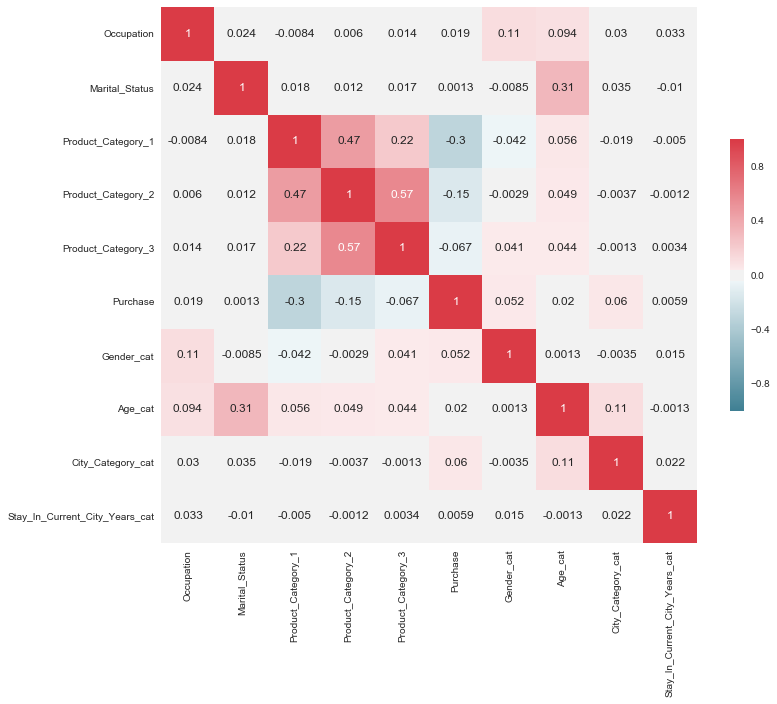

In [123]:
feature_selected = ['Occupation','Marital_Status',
       'Product_Category_1', 'Product_Category_2', 'Product_Category_3',
       'Purchase','Gender_cat', 'Age_cat', 'City_Category_cat',
       'Stay_In_Current_City_Years_cat']

plt.figure(figsize=(12,10))
corr = df_eda[feature_selected].corr()
# generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, cmap=cmap, vmin=-1, vmax=1, center=0,
            square=True, annot=True, cbar_kws={'shrink':.5})
plt.show()

From the correlation matrix above, we could find that the significant positive/negative correlation between variables:

Positvie correlation:
    - Gender vs Occupation
    - Martital_Status vs Age
    - Product_Category_1 vs Product_Category_2
    - Product_Category_1 vs Product_Category_3
    - Product_Category_1 vs Age
    
Negative correlation:
    - Purchase vs Product_Category_1
    - Purchase vs Product_Category_2
    - Purchase vs Product_Category_3    

Let's now look at the distributions of the features.

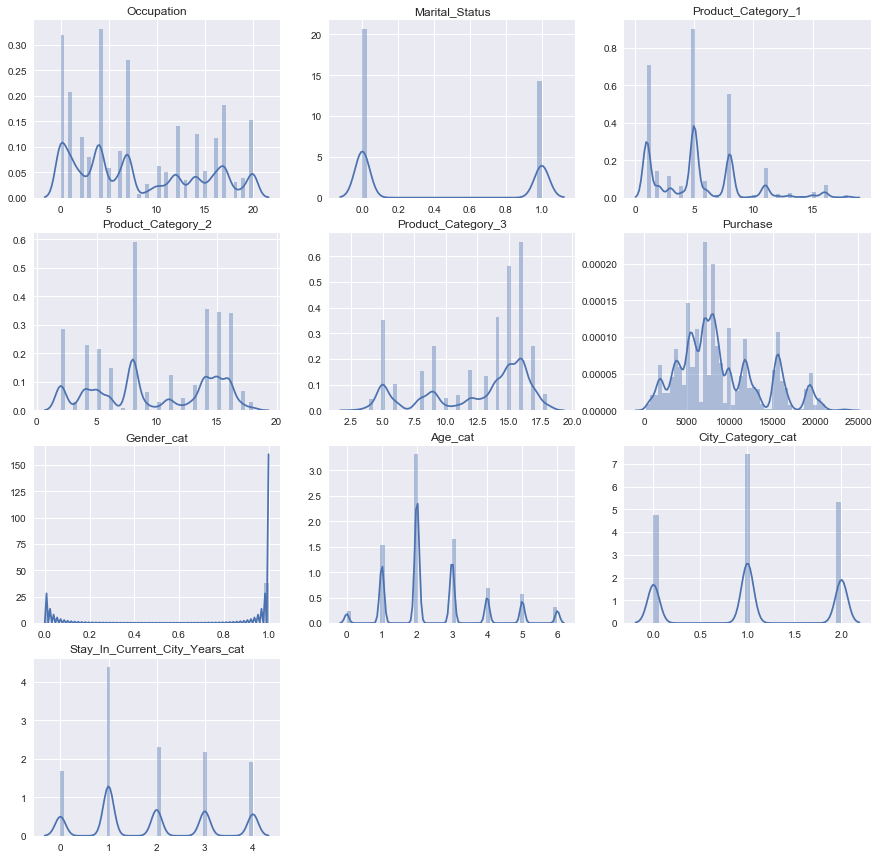

In [15]:
feature_selected = ['Occupation','Marital_Status',
       'Product_Category_1', 'Product_Category_2', 'Product_Category_3',
       'Purchase','Gender_cat', 'Age_cat', 'City_Category_cat',
       'Stay_In_Current_City_Years_cat']

plt.figure(figsize=(15,15))
for i in range(len(feature_selected)):
    feature_this = df_eda[feature_selected[i]]
    feature_this = feature_this.dropna()
    plt.subplot(4,3,i+1)
    plt.title(feature_selected[i])
    sns.distplot(feature_this)
    plt.xlabel('')
plt.show()

## 2. Feature Engineering



### 2.1 Feature Importance

Here we train Randon Forest Classifier among all features as baseline model, which reaches 56.14% test accuracy. The main purpose here is to obtain the feature importance for further feature engineering.

In [16]:
def normalize(data):
    return (data - np.mean(data)) / np.std(data)

In [60]:
# Transform data to have rows at a product id level
df_product = df.groupby(by='Product_ID', as_index=False).agg(
    {'User_ID': pd.Series.nunique,
     'Age': lambda x:x.value_counts().index[0],
     'Occupation': lambda x:x.value_counts().index[0],
     'City_Category': lambda x:x.value_counts().index[0],
     'Stay_In_Current_City_Years': lambda x:x.value_counts().index[0],
     'Marital_Status': lambda x:x.value_counts().index[0],
     'Product_Category_1': lambda x: x.iloc[0],
    'Product_Category_2': lambda x: x.iloc[0],
    'Product_Category_3': lambda x: x.iloc[0],
    'Purchase': lambda x: np.mean(x)}
)

In [61]:
# Fill NaN with 0
df_product['Product_Category_2'].fillna(0, inplace=True)
df_product['Product_Category_3'].fillna(0, inplace=True)

# Normalize purchase amount
df_product['Purchase'] = normalize(df_product['Purchase'])


In [62]:
df_train = df_product[df_product.Product_Category_1 != -1]
df_test = df_product[df_product.Product_Category_1 == -1] # Not to be touched until the model is trained and ready

# Divide the training data into test and train data to measure accuracy
y = df_train['Product_Category_1']
X = df_train.drop(['Product_Category_1','Product_ID'], axis=1)
X = pd.get_dummies(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)


In [63]:
rf = RandomForestClassifier(n_estimators=100, max_depth=6,random_state=0)
rf = rf.fit(X_train, y_train)

y_pred = rf.predict(X_train)
print('Training data accuracy', float(accuracy_score(y_pred, y_train))*100, '%')

y_pred = rf.predict(X_test)
print('Testing data accuracy', float(accuracy_score(y_pred, y_test))*100, '%')

Training data accuracy 65.20395550061805 %
Testing data accuracy 56.14035087719298 %


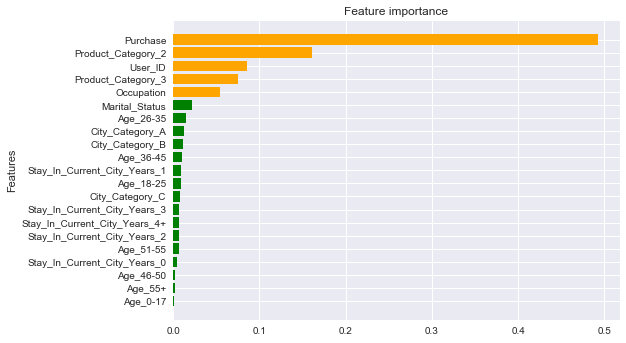

In [65]:
sorted(zip(map(lambda x: round(x,4), rf.feature_importances_), X_train.columns), reverse = True)

features = X_train.columns
importances = rf.feature_importances_
idx = np.argsort(importances)
plt.title("Feature importance")
for i in range(len(idx)):
    if importances[idx[i]] > 0.05:
        plt.barh(i, importances[idx[i]], color = 'orange')
    else:
        plt.barh(i, importances[idx[i]], color = 'g')
plt.yticks(range(len(idx)), [features[i] for i in idx])
plt.ylabel("Features")
plt.show()

### 2.2 Features to use

From the result of correlation matrix, I choose Product_Category_2, Product_Category_3, Purchases as necessary features.
In addition, the feature importance from the baseline randon forest indicates that Age, City, Stay Year are not that significant, so let's drop them.


In [22]:
def data_preprocessing(df):

    df_product = df.groupby(by='Product_ID', as_index=False).agg(
        {'User_ID': pd.Series.nunique,
         'Occupation': lambda x:x.value_counts().index[0],
         'Marital_Status': lambda x:x.value_counts().index[0],
         'Product_Category_1': lambda x: x.iloc[0],
         'Product_Category_2': lambda x: x.iloc[0],
         'Product_Category_3': lambda x: x.iloc[0],
         'Purchase': lambda x: np.mean(x)
        }
    )

    # Fill NaN with 19
    df_product['Product_Category_2'].fillna(19, inplace=True)
    df_product['Product_Category_3'].fillna(19, inplace=True)

    # Normalize purchase amount
    df_product['Purchase'] = normalize(df_product['Purchase'])
    
    return df_product

In [23]:
df_product = data_preprocessing(df)

df_train = df_product[df_product.Product_Category_1 != -1]
df_test = df_product[df_product.Product_Category_1 == -1] # Not to be touched until the model is trained and ready

# Divide the training data into test and train data to measure accuracy
y = df_train['Product_Category_1']
X = df_train.drop(['Product_Category_1','Product_ID'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

## 3. Models and Stacking Experiment

I try different models such as Decision Tree, Random Forest, Multi-layer Perceptron, Logistic regression, AdaBoost, XGBoost, and use stacking methods to combine these model.

Let's start with a logistic regression model.

In [24]:
# To store the model accuracy
train_score = []
test_score = []

### 3.1 Logistic Regression

In [25]:
lr = LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial')
lr = lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)
print('Training data accuracy', float(accuracy_score(y_pred, y_train))*100, '%')
train_score.append(float(accuracy_score(y_pred, y_train)))

y_pred = lr.predict(X_test)
print('Testing data accuracy', float(accuracy_score(y_pred, y_test))*100, '%')
test_score.append(float(accuracy_score(y_pred, y_test)))


Training data accuracy 39.55500618046972 %
Testing data accuracy 39.34837092731829 %


### 3.2 Decision Tree

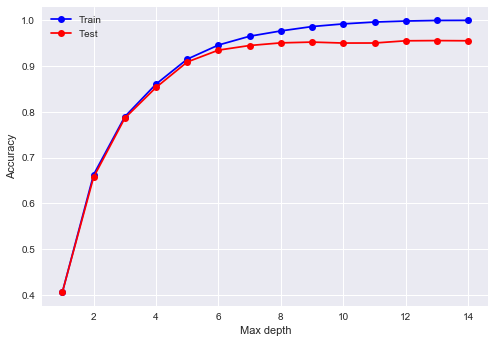

In [53]:
# use cross validation to get the best max_depth
result_train = []
result_test = []
max_depth = range(1,15)
for i in max_depth:
    clf = DecisionTreeClassifier(criterion='entropy',max_depth=i)
    scores = cross_validate(clf, X, y, cv=10, return_train_score=True)
    result_train.append(scores['train_score'].mean())
    result_test.append(scores['test_score'].mean()) 

plt.figure()
plt.plot(max_depth, result_train, '-o',color='blue',label='Train')
plt.plot(max_depth, result_test, '-o',color='red',label='Test')
plt.xlabel('Max depth')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [27]:
clf = DecisionTreeClassifier(max_depth=6)
clf = clf.fit(X_train, y_train)

y_pred = clf.predict(X_train)
print('Training data accuracy', float(accuracy_score(y_pred, y_train))*100, '%')
train_score.append(float(accuracy_score(y_pred, y_train)))

y_pred = clf.predict(X_test)
print('Testing data accuracy', float(accuracy_score(y_pred, y_test))*100, '%')
test_score.append(float(accuracy_score(y_pred, y_test)))

Training data accuracy 71.9406674907293 %
Testing data accuracy 65.16290726817043 %


### 3.3 Random Forest

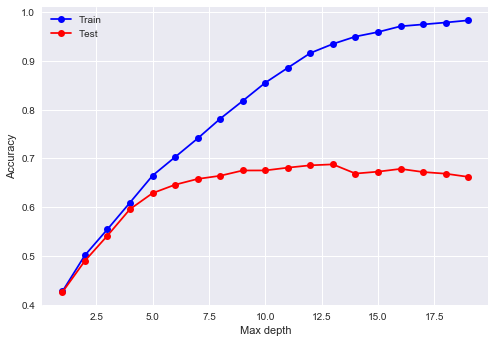

In [28]:
# use cross validation to get the best max_depth

result_train = []
result_test = []
max_depth = range(1,20)
for i in max_depth:
    rf = RandomForestClassifier(max_depth=i)
    scores = cross_validate(rf, X, y, cv=10, return_train_score=True)
    result_train.append(scores['train_score'].mean())
    result_test.append(scores['test_score'].mean()) 

plt.figure()
plt.plot(max_depth, result_train, '-o',color='blue',label='Train')
plt.plot(max_depth, result_test, '-o',color='red',label='Test')
plt.xlabel('Max depth')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [29]:
rf = RandomForestClassifier(n_estimators=100, max_depth=16,random_state=0)
rf = rf.fit(X_train, y_train)

y_pred = rf.predict(X_train)
print('Training data accuracy', float(accuracy_score(y_pred, y_train))*100, '%')
train_score.append(float(accuracy_score(y_pred, y_train)))

y_pred = rf.predict(X_test)
print('Testing data accuracy', float(accuracy_score(y_pred, y_test))*100, '%')
test_score.append(float(accuracy_score(y_pred, y_test)))

Training data accuracy 99.50556242274413 %
Testing data accuracy 68.29573934837093 %


### 3.3 Multi-layer Perceptron classifier

In [30]:
mlp = MLPClassifier(solver='lbfgs', activation='tanh', hidden_layer_sizes=(10, 10,), random_state=1, max_iter=500)
mlp = mlp.fit(X_train, y_train)

y_pred = mlp.predict(X_train)
print('Training data accuracy', float(accuracy_score(y_pred, y_train))*100, '%')
train_score.append(float(accuracy_score(y_pred, y_train)))

y_pred = mlp.predict(X_test)
print('Testing data accuracy', float(accuracy_score(y_pred, y_test))*100, '%')
test_score.append(float(accuracy_score(y_pred, y_test)))


Training data accuracy 54.635352286773795 %
Testing data accuracy 56.51629072681704 %


### 3.5 AdaBoost

In [31]:
abc = AdaBoostClassifier(base_estimator=clf, n_estimators=200)
abc = abc.fit(X_train, y_train)

y_pred = abc.predict(X_train)
print('Training data accuracy', float(accuracy_score(y_pred, y_train))*100, '%')
train_score.append(float(accuracy_score(y_pred, y_train)))


y_pred = abc.predict(X_test)
print('Testing data accuracy', float(accuracy_score(y_pred, y_test))*100, '%')
test_score.append(float(accuracy_score(y_pred, y_test)))


Training data accuracy 89.74042027194066 %
Testing data accuracy 67.66917293233082 %


### 3.6 XGBoost

In [32]:
gbm = XGBClassifier(max_depth= 5, n_estimators=100, learning_rate=0.05)
gbm = gbm.fit(X_train, y_train)

y_pred = gbm.predict(X_train)
print('Training data accuracy', float(accuracy_score(y_pred, y_train))*100, '%')
train_score.append(float(accuracy_score(y_pred, y_train)))


y_pred = gbm.predict(X_test)
print('Testing data accuracy', float(accuracy_score(y_pred, y_test))*100, '%')
test_score.append(float(accuracy_score(y_pred, y_test)))


Training data accuracy 85.59950556242273 %
Testing data accuracy 69.79949874686717 %


### 3.7 Stacking

A great thing about stacking is that not only using different set of models, but also creating the same models with a different set of features. 

But here I just try to use same features with different models along with 3-fold cross validation.



In [33]:
kf = KFold(n_splits=3, random_state=1)

In [34]:
def kf_pred(kf, model, X_train, y_train, X_test):
    
    ntrain = X_train.shape[0]
    ntest = X_test.shape[0]
    
    kf_train = np.zeros((ntrain,))
    kf_test_all = np.empty((kf.get_n_splits(), ntest))
    
    for i, (train_index, test_index) in enumerate(kf.split(X_train)):
        kf_X_train = X_train.iloc[train_index]
        kf_y_train = y_train.iloc[train_index]
        kf_X_test = X_train.iloc[test_index]
        
        model.fit(kf_X_train, kf_y_train)
        
        kf_train[test_index] = model.predict(kf_X_test)
        kf_test_all[i, :] = model.predict(X_test)
        
    return kf_train.reshape(-1,1), stats.mode(kf_test_all)[0]
        

In [35]:
def stack_data(model_list, X, y, df_test):

    stack_train = np.zeros((X.shape[0], len(model_list)))
    stack_test = np.zeros((df_test.shape[0] , len(model_list)))

    for i, model in enumerate(model_list):
        
        strain, stest = kf_pred(kf, model, X, y, df_test)
        stack_train[:,i] = strain.reshape(X.shape[0],)
        stack_test[:,i] = stest
        
    return stack_train, stack_test


In [36]:
def accuracy(X_train, y_train, X_test, y_test, model):
    model.fit(X_train, y_train)
    y_train_pred = model.score(X_train, y_train)
    y_test_pred = model.score(X_test, y_test)
    
    return y_train_pred, y_test_pred

In [37]:
# for stacking
model_list = [rf, clf, gbm]

# for final prediction
second_model_list = [rf, clf, gbm, mlp, abc]

In [38]:
stack_train, stack_test = stack_data(model_list, X_train, y_train, X_test)

In [39]:
for model in second_model_list:
    print(accuracy(stack_train, y_train, stack_test, y_test, model))

(0.7478368355995055, 0.7017543859649122)
(0.7212608158220025, 0.6954887218045113)
(0.738566131025958, 0.6967418546365914)
(0.6786155747836835, 0.6917293233082706)
(0.5488257107540173, 0.5137844611528822)


In [40]:
train_score.append(accuracy(stack_train, y_train, stack_test, y_test, clf)[0])
test_score.append(accuracy(stack_train, y_train, stack_test, y_test, clf)[1])


### 3.8 Model Comparison 

In [124]:
model_info = pd.DataFrame(
    data={'Model': ['Logistic Regression', 'Decision Tree', 'Random Forest', 'MLP','AdaBoost','XGBoost','Stacking'],
          'Train Score': train_score,
          'Test Score':test_score
          })

pd.options.display.float_format = '{:1,.2f}'.format

In [125]:
model_info

,Model,Train Score,Test Score
0,Logistic Regression,0.40,0.39
1,Decision Tree,0.72,0.65
2,Random Forest,1.00,0.68
3,MLP,0.55,0.57
4,AdaBoost,0.90,0.68
5,XGBoost,0.86,0.70
6,Stacking,0.72,0.69


## 4. FInal Model

From the test above, we find that the training score from all models are not high enough, that means we haven't better fit the training data. Therefore, we should add more useful features or use bigger network. 

As 'Purchase' has significant effect on predicting 'Product Category 1', I draw the scatter plot below to better know more clear relationship between these two factors. 

In this figure, we find that the distributions of purchase amount among different product category are significantly different. Therefore, apart from the mean of the purchase amount, I create more features such as the maximum/minimum/standard deviation of the purchase amount. 


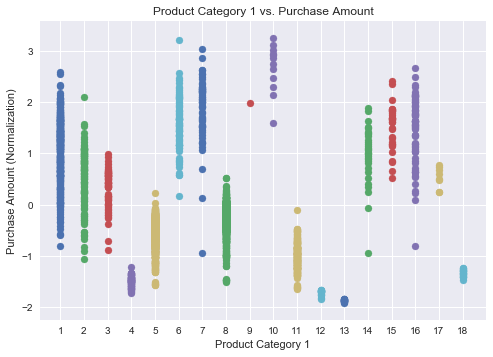

In [120]:
for i in np.arange(1,19,1):
    plt.scatter(df_train[df_train.Product_Category_1 ==i].Product_Category_1, df_train[df_train.Product_Category_1 ==i].Purchase, cmap='greens')

plt.xticks(np.arange(1,19,1))
plt.title('Product Category 1 vs. Purchase Amount')
plt.xlabel('Product Category 1')
plt.ylabel('Purchase Amount (Normalization)')
plt.show()

### 4.1 Add more features

In [127]:
def final_data_preprocessing(df):

    df['Purchase_max'] = df['Purchase']
    df['Purchase_min'] = df['Purchase']
    df['Purchase_mean'] = df['Purchase']
    df['Purchase_sum'] = df['Purchase']
    df['Purchase_std'] = df['Purchase']
    
    df_product = df.groupby(by='Product_ID', as_index=False).agg(
        {'User_ID': pd.Series.nunique,
         'Occupation': lambda x:x.value_counts().index[0],
         'Marital_Status': lambda x:x.value_counts().index[0],
         'Product_Category_1': lambda x: x.iloc[0],
         'Product_Category_2': lambda x: x.iloc[0],
         'Product_Category_3': lambda x: x.iloc[0],
         'Purchase_max': lambda x: x.max(),
         'Purchase_min': lambda x: x.min(),
         'Purchase_mean': lambda x: np.mean(x),
         'Purchase_sum': lambda x: sum(x),
         'Purchase_std': lambda x: np.std(x)
        }
    )

    # Fill NaN with the 19
    df_product['Product_Category_2'].fillna(19, inplace=True)
    df_product['Product_Category_3'].fillna(19, inplace=True)

    # Normalize purchase amount
    # df_product['Purchase'] = normalize(df_product['Purchase'])
    
    return df_product

In [128]:
df_product = final_data_preprocessing(df)

df_train = df_product[df_product.Product_Category_1 != -1]
df_test = df_product[df_product.Product_Category_1 == -1] # Not to be touched until the model is trained and ready

# Divide the training data into test and train data to measure accuracy
y = df_train['Product_Category_1']
X = df_train.drop(['Product_Category_1','Product_ID'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [129]:
df_test_id = df_test.Product_ID
df_test = df_test.drop(['Product_ID','Product_Category_1'], axis=1)

### 4.2 Random Forest

In [48]:
# Create the parameter grid
param_grid = {
    'bootstrap': [True],
    'max_depth': [6,9,12],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12]
}
# Create a based model
# Instantiate the grid search model
rf_cv = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)
rf_cv.fit(X_train, y_train)

Fitting 3 folds for each of 54 candidates, totalling 162 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   25.7s
[Parallel(n_jobs=-1)]: Done 162 out of 162 | elapsed:   27.1s finished


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=16, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'bootstrap': [True], 'max_depth': [6, 9, 12], 'max_features': [2, 3], 'min_samples_leaf': [3, 4, 5], 'min_samples_split': [8, 10, 12]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=2)

In [130]:
rf_cv.score(X_train, y_train)

0.9820766378244746

In [49]:
rf_cv.score(X_test, y_test)

0.9285714285714286

### 4.3 XGBoost

In [50]:
# Define a hyper-parameter space to search. 
parameter_space = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5,1.5, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.8, 1.0],
        'max_depth': [3, 4, 5]
}

gbm_cv = GridSearchCV(gbm, parameter_space, cv=3)
gbm_cv.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.05, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'min_child_weight': [1, 5, 10], 'gamma': [0.5, 1.5, 5], 'subsample': [0.6, 0.8, 1.0], 'colsample_bytree': [0.8, 1.0], 'max_depth': [3, 4, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [51]:
print('Best parameters found:\n', gbm_cv.best_params_)
print('Test score:', gbm_cv.score(X_train, y_train))

Best parameters found:
 {'colsample_bytree': 0.8, 'gamma': 0.5, 'max_depth': 3, 'min_child_weight': 1, 'subsample': 1.0}
Test score: 0.9864029666254636


In [131]:
gbm_cv.score(X_train, y_train)

0.9864029666254636

In [52]:
gbm_cv.score(X_test, y_test)

0.9423558897243107

In [142]:
final_model_info = pd.DataFrame(
    data={'Model': ['Random Forest', 'XGBoost'],
          'Train Score': [rf_cv.score(X_train, y_train), gbm_cv.score(X_train, y_train)],
          'Test Score':[rf_cv.score(X_test, y_test), gbm_cv.score(X_test, y_test)]
          })

pd.options.display.float_format = '{:1,.2f}'.format

In [143]:
final_model_info

,Model,Train Score,Test Score
0,Random Forest,0.98,0.93
1,XGBoost,0.99,0.94


### 4.4 Prediction

The test accuracy of random forest is 0.928 and that from XGBoost is 0.942 after grid search. 

Therefore, let’s choose XGBoost to do the final prediction.


In [56]:
gbm_ = XGBClassifier(colsample_bytree= 0.8, gamma= 0.5, max_depth= 3, min_child_weight= 1, subsample= 1.0, n_estimators=100, learning_rate=0.05, random_state = 0)
gbm_ = gbm_.fit(X, y)

In [58]:
### Submission to Kaggle
### y_pred_test = gbm_.predict(df_test)
### write to submission file
### df = pd.DataFrame({'Product_ID': df_test_id,'Product_Category_1': y_pred_test})
### df.to_csv('submission_file.csv', index=False)

## 5. Result

After doing feature engineering and tuning the hyperparameters, the XGBoost model obtains **96.96%** accuracy score on Kaggle.